In [1]:
import geopandas as gpd

# Define the path to your shapefile
shapefile_path = r"C:\Users\daves\OneDrive\Pessoal\Notebooks\Mapa sudeste\BR_Municipios_2024\BR_Municipios_2024.shp"
# Read the shapefile
gdf = gpd.read_file(shapefile_path)

In [2]:
# Define the list of states you want to filter for
states_to_filter = ['MG', 'SP', 'ES', 'RJ']

# Filter the GeoDataFrame
filtered_gdf = gdf[gdf['SIGLA_UF'].isin(states_to_filter)]

In [3]:
# Dissolve the states
states_dissolved_gdf = filtered_gdf[['geometry', 'SIGLA_UF']].dissolve(by='SIGLA_UF')
states_dissolved_gdf        

,geometry
SIGLA_UF,
ES,"MULTIPOLYGON (((-40.88317 -21.16304, -40.88319..."
MG,"POLYGON ((-46.58513 -22.43945, -46.58933 -22.4..."
RJ,"MULTIPOLYGON (((-44.71817 -23.35725, -44.71816..."
SP,"MULTIPOLYGON (((-50.83067 -22.86217, -50.83292..."


In [4]:
# Identify the specific municipalities (capitals)
capital_names = ['São Paulo', 'Rio de Janeiro', 'Vitória', 'Belo Horizonte']
capitals_gdf = filtered_gdf[filtered_gdf['NM_MUN'].isin(capital_names)]

C:\Users\daves\AppData\Local\Temp\ipykernel_24404\3698221172.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for city_centroid_x, city_centroid_y, city_label in zip(capitals_gdf.geometry.centroid.x,
C:\Users\daves\AppData\Local\Temp\ipykernel_24404\3698221172.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  capitals_gdf.geometry.centroid.y,


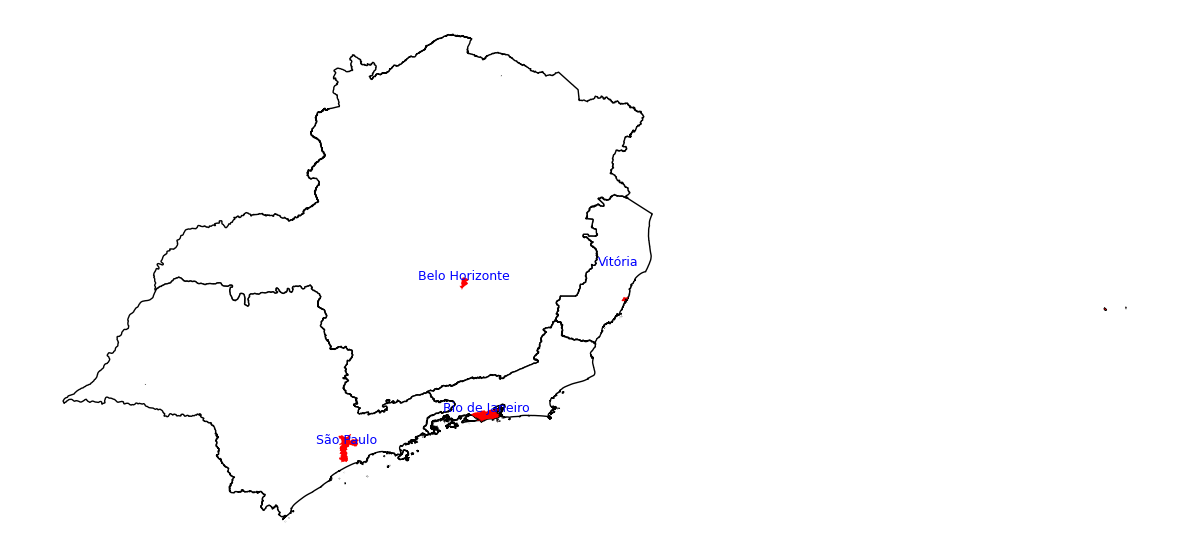

In [5]:
import matplotlib.pyplot as plt

# A4 paper landscape dimensions in inches
a4_landscape_width_inches = 297 / 25.4  # Approx 11.69 inches
a4_landscape_height_inches = 210 / 25.4 # Approx 8.27 inches

# Create the figure with A4 landscape size
fig, ax = plt.subplots(1, 1, figsize=(a4_landscape_width_inches, a4_landscape_height_inches))

# Adjust subplot parameters so the axes fill the entire figure
# This is important for the map to be centered on the page eventually
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)

# Plot the dissolved state boundaries
# GeoPandas will automatically set the xlim and ylim to fit this data
states_dissolved_gdf.plot(
    ax=ax,
    edgecolor='black',
    color='white',
    alpha=1.0,
)

# Plot the capital cities on top
capitals_gdf.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=50,
)

# Get ES state geometry for Vitória's label placement
if 'ES' in states_dissolved_gdf.index:
    es_state_geometry = states_dissolved_gdf.loc['ES'].geometry
else:
    es_state_geometry = None # Fallback if ES is not found

# Annotate capital city names
for city_centroid_x, city_centroid_y, city_label in zip(capitals_gdf.geometry.centroid.x,
                                                        capitals_gdf.geometry.centroid.y,
                                                        capitals_gdf['NM_MUN']):
    
    annotation_x, annotation_y = city_centroid_x, city_centroid_y

    if city_label == 'Vitória' and es_state_geometry:
        es_repr_point = es_state_geometry.representative_point()
        annotation_x = es_repr_point.x
        annotation_y = es_repr_point.y
    
    ax.text(annotation_x, annotation_y, city_label,
            fontsize=9, ha='center', va='bottom', color='blue')

# Ensure the aspect ratio of the axes is equal and center the content
# 'adjustable='box'' will adjust the data limits to achieve the aspect ratio,
# centering the map within the axes. Since axes fill the figure, it centers on the page.
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()

output_path = r"C:\Users\daves\OneDrive\Pessoal\Notebooks\Mapa sudeste\Mapa_sudeste_A4_paisagem.pdf"
# Save the entire A4 page, with the map centered and maximized
plt.savefig(output_path, dpi=1200)
plt.show()

In [6]:
import requests
from PIL import Image, UnidentifiedImageError # Explicitly import UnidentifiedImageError
from io import BytesIO
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import os
import geopandas as gpd

# --- Constants for A4 Page (Portrait) ---
A4_WIDTH_INCHES = 8.27
A4_HEIGHT_INCHES = 11.69
# Padding around the map content within the A4 page, as a fraction of page dimension
MAP_PADDING_FRACTION_WIDTH = 0.05 # 5% padding on left/right
MAP_PADDING_FRACTION_HEIGHT = 0.05 # 5% padding on top/bottom

# --- 1. Data Loading and Preparation ---
shapefile_path = r"C:\Users\daves\OneDrive\Pessoal\Notebooks\Mapa sudeste\BR_Municipios_2024\BR_Municipios_2024.shp"
try:
    gdf_municipalities = gpd.read_file(shapefile_path)
except Exception as e:
    print(f"CRITICAL ERROR: Could not load shapefile: {e}")
    print("Please ensure the shapefile path is correct and the file is accessible.")
    # Exiting if shapefile can't be loaded, as it's crucial.
    exit()


states_to_process = ['MG', 'SP', 'ES', 'RJ']
capital_names_list = ['Belo Horizonte', 'São Paulo', 'Vitória', 'Rio de Janeiro']

# Filter municipalities for the specified states
filtered_municipalities = gdf_municipalities[gdf_municipalities['SIGLA_UF'].isin(states_to_process)].copy()

# Dissolve geometries by state
all_states_dissolved = filtered_municipalities[['geometry', 'SIGLA_UF']].dissolve(by='SIGLA_UF')

# Filter for capitals
all_capitals = filtered_municipalities[filtered_municipalities['NM_MUN'].isin(capital_names_list)].copy()

image_urls = {
    'SP': 'https://jornalismojunior.com.br/wp-content/uploads/2024/01/Sesc_Avenida_Paulista_1_cropped-scaled.jpg',
    'RJ': 'https://images.pexels.com/photos/16808665/pexels-photo-16808665.jpeg?cs=srgb&dl=pexels-kash-ous-75311439-16808665.jpg&fm=jpg',
    'ES': r"C:\Users\daves\OneDrive\Pessoal\Notebooks\Mapa sudeste\vitoria.jpg", # LOCAL PATH
    'MG': 'https://live.staticflickr.com/7416/9907709743_e2d2769178_b.jpg'
}

# Using a distinct output directory to avoid conflicts
output_directory = r"C:\Users\daves\OneDrive\Pessoal\Notebooks\Mapa sudeste\Individual_State_Maps_Corrected"
os.makedirs(output_directory, exist_ok=True)

# --- 2. Loop Through Each State to Create Individual Plots ---
for state_code in states_to_process:
    print(f"\nProcessing state: {state_code}")

    fig = None # Initialize fig
    ax = None  # Initialize ax

    if state_code not in all_states_dissolved.index:
        print(f"  State {state_code} not found in dissolved geometries. Skipping.")
        continue
    
    single_state_gdf = all_states_dissolved.loc[[state_code]]
    current_state_geometry = single_state_gdf.geometry.iloc[0]
    # Filter capitals for the current state
    current_capital = all_capitals[all_capitals['SIGLA_UF'] == state_code].copy()


    # Get state geometry bounds and dimensions (in data coordinates)
    s_minx, s_miny, s_maxx, s_maxy = current_state_geometry.bounds
    state_width_data = s_maxx - s_minx
    state_height_data = s_maxy - s_miny

    if not (state_width_data > 0 and state_height_data > 0): # Check for valid, non-zero area geometry
        print(f"  State {state_code} geometry has zero width or height. Plot generation might be problematic.")
        # Create a placeholder error plot
        fig_width_err = A4_WIDTH_INCHES if state_code == 'ES' else 5
        fig_height_err = A4_HEIGHT_INCHES if state_code == 'ES' else 5
        fig, ax = plt.subplots(1,1, figsize=(fig_width_err, fig_height_err))
        ax.text(0.5, 0.5, f"Error:\nZero dimension geometry\nfor state {state_code}", 
                ha='center', va='center', color='red', fontsize=10)
        # ax will be further processed (set_axis_off, savefig, close)
    elif state_code == 'ES':
        print(f"  Setting A4 portrait layout for {state_code}")
        fig = plt.figure(figsize=(A4_WIDTH_INCHES, A4_HEIGHT_INCHES))

        state_aspect_ratio_data = state_height_data / state_width_data

        drawable_width_inches = A4_WIDTH_INCHES * (1 - 2 * MAP_PADDING_FRACTION_WIDTH)
        drawable_height_inches = A4_HEIGHT_INCHES * (1 - 2 * MAP_PADDING_FRACTION_HEIGHT)
        drawable_aspect_ratio_inches = drawable_height_inches / drawable_width_inches

        ax_content_width_inches = 0
        ax_content_height_inches = 0

        if state_aspect_ratio_data > drawable_aspect_ratio_inches:
            ax_content_height_inches = drawable_height_inches
            ax_content_width_inches = ax_content_height_inches / state_aspect_ratio_data
        else:
            ax_content_width_inches = drawable_width_inches
            ax_content_height_inches = ax_content_width_inches * state_aspect_ratio_data
        
        ax_width_norm = ax_content_width_inches / A4_WIDTH_INCHES
        ax_height_norm = ax_content_height_inches / A4_HEIGHT_INCHES
        ax_left_norm = (1 - ax_width_norm) / 2 # Center horizontally
        ax_bottom_norm = (1 - ax_height_norm) / 2 # Center vertically
        
        print(f"  ES - State data H/W ratio: {state_aspect_ratio_data:.2f}")
        print(f"  ES - Drawable area on A4 H/W ratio: {drawable_aspect_ratio_inches:.2f}")
        print(f"  ES - Calculated map content (inches): W={ax_content_width_inches:.2f}, H={ax_content_height_inches:.2f}")
        print(f"  ES - Axes normalized params: L={ax_left_norm:.3f}, B={ax_bottom_norm:.3f}, W={ax_width_norm:.3f}, H={ax_height_norm:.3f}")

        ax = fig.add_axes([ax_left_norm, ax_bottom_norm, ax_width_norm, ax_height_norm])

        # --- CRITICAL FIX for ES: Explicitly set the data limits of the axes to the state's bounds ---
        ax.set_xlim(s_minx, s_maxx)
        ax.set_ylim(s_miny, s_maxy)
        print(f"  ES - Axes data limits set to: xlim=({s_minx:.2f}, {s_maxx:.2f}), ylim=({s_miny:.2f}, {s_maxy:.2f})")

    else: # For other states (MG, SP, RJ)
        current_figsize = (10, 10) # Default square figsize
        print(f"  Setting default figsize for {state_code}: {current_figsize}")
        fig, ax = plt.subplots(1, 1, figsize=current_figsize)
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1) # Axes fills the figure

    # --- Plotting state boundary (common for all valid geometries with an axes) ---
    if ax is not None and (state_width_data > 0 and state_height_data > 0):
        single_state_gdf.plot(
            ax=ax, edgecolor='black', color='white', alpha=1.0, zorder=1
        )

        # --- Image processing and plotting ---
        if state_code in image_urls:
            img_path_or_url = image_urls[state_code]
            np_img = None
            pil_img = None

            if img_path_or_url.lower().startswith('http://') or img_path_or_url.lower().startswith('https://'):
                try:
                    print(f"  Fetching image for {state_code} from URL: {img_path_or_url}...")
                    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
                    response = requests.get(img_path_or_url, headers=headers, timeout=20)
                    response.raise_for_status()
                    pil_img = Image.open(BytesIO(response.content))
                    np_img = np.array(pil_img.convert("RGBA"))
                except requests.exceptions.RequestException as e:
                    print(f"  Error downloading image for {state_code}: {e}")
                except UnidentifiedImageError as e: 
                    print(f"  Error: Pillow (PIL) cannot identify image file from URL for {state_code}. {e}")
                except Exception as e:
                    print(f"  Error processing downloaded image for {state_code}: {e}")
            else: # Local file path
                try:
                    if not os.path.exists(img_path_or_url):
                        print(f"  ERROR: Local file does NOT exist at: {img_path_or_url}")
                    else:
                        print(f"  Loading local image for {state_code} from path: {img_path_or_url}")
                        pil_img = Image.open(img_path_or_url)
                        np_img = np.array(pil_img.convert("RGBA"))
                except FileNotFoundError: # Should be caught by os.path.exists, but good to have
                    print(f"  Error: Local file not found for {state_code}: {img_path_or_url}")
                except UnidentifiedImageError as e:
                    print(f"  Error: Pillow (PIL) cannot identify local image file for {state_code}. {e}")
                except Exception as e:
                    print(f"  Error processing local image for {state_code}: {e}")
            
            if np_img is not None and pil_img is not None:
                img_pil_width, img_pil_height = pil_img.size
                if img_pil_width > 0 and img_pil_height > 0:
                    img_aspect_ratio_hw = img_pil_height / img_pil_width
                    s_bbox_aspect_ratio_hw = state_height_data / state_width_data
                    
                    imshow_h, imshow_w = 0,0
                    imshow_x_min_calc, imshow_x_max_calc = 0,0
                    imshow_y_min_calc, imshow_y_max_calc = 0,0

                    # Calculate image extent to fit/fill the state's bounding box, preserving image aspect ratio
                    if img_aspect_ratio_hw > s_bbox_aspect_ratio_hw: # Image is taller/skinnier than state bbox
                        imshow_h = state_height_data
                        imshow_w = imshow_h / img_aspect_ratio_hw
                        imshow_x_min_calc = s_minx + (state_width_data - imshow_w) / 2
                        imshow_x_max_calc = imshow_x_min_calc + imshow_w
                        imshow_y_min_calc = s_miny
                        imshow_y_max_calc = s_maxy
                    else: # Image is wider/shorter or same aspect as state bbox
                        imshow_w = state_width_data
                        imshow_h = imshow_w * img_aspect_ratio_hw
                        imshow_y_min_calc = s_miny + (state_height_data - imshow_h) / 2
                        imshow_y_max_calc = imshow_y_min_calc + imshow_h
                        imshow_x_min_calc = s_minx
                        imshow_x_max_calc = s_maxx
                    
                    current_imshow_extent = (imshow_x_min_calc, imshow_x_max_calc, imshow_y_min_calc, imshow_y_max_calc)
                    img_artist = ax.imshow(np_img, extent=current_imshow_extent, aspect='auto', origin='upper', zorder=1.5)

                    # Create clipping path from state geometry
                    path_data_clip = []
                    polygons_for_clip = []
                    if current_state_geometry.geom_type == 'Polygon':
                        polygons_for_clip.append(current_state_geometry)
                    elif current_state_geometry.geom_type == 'MultiPolygon':
                        polygons_for_clip.extend(list(current_state_geometry.geoms)) # Use list() for MultiPolygon

                    for poly_clip in polygons_for_clip:
                        exterior_coords_clip = list(poly_clip.exterior.coords)
                        path_data_clip.append((Path.MOVETO, exterior_coords_clip[0]))
                        for coord_clip_ext in exterior_coords_clip[1:]: path_data_clip.append((Path.LINETO, coord_clip_ext))
                        path_data_clip.append((Path.CLOSEPOLY, exterior_coords_clip[-1])) # Use last point for CLOSEPOLY
                        for interior_clip in poly_clip.interiors:
                            interior_coords_clip = list(interior_clip.coords)
                            path_data_clip.append((Path.MOVETO, interior_coords_clip[0]))
                            for coord_clip_int in interior_coords_clip[1:]: path_data_clip.append((Path.LINETO, coord_clip_int))
                            path_data_clip.append((Path.CLOSEPOLY, interior_coords_clip[-1])) # Use last point for CLOSEPOLY
                    
                    if path_data_clip:
                        codes_clip, verts_clip = zip(*path_data_clip)
                        clip_path_obj = Path(verts_clip, codes_clip)
                        patch_for_clipping = PathPatch(clip_path_obj, transform=ax.transData)
                        img_artist.set_clip_path(patch_for_clipping)
                        print(f"  Image for {state_code} processed and clipped.")
                    else: 
                        print(f"  Warning: No path data for clipping image for {state_code}, image will not be clipped.")
                else:
                    print(f"  Skipping image plotting for {state_code} due to invalid image dimensions (width or height is zero).")
            else:
                print(f"  Image data (np_img or pil_img) is None for {state_code}. Skipping image plotting.")
        else:
            print(f"  No image URL defined for state {state_code}, skipping image plotting.")

        # --- Capital plotting ---
        if not current_capital.empty:
            # Ensure capital geometry is valid before trying to plot/get centroid
            valid_capitals = current_capital[current_capital.geometry.is_valid & ~current_capital.geometry.is_empty]
            if not valid_capitals.empty:
                valid_capitals.plot(
                    ax=ax, marker='o', color='red', markersize=80,
                    edgecolor='black', linewidth=0.5, zorder=3
                )
                capital_row = valid_capitals.iloc[0]
                city_label = capital_row['NM_MUN']
                
                # Use representative_point for annotation to ensure it's within the polygon
                # Capital's own geometry representative point is usually better for label than state's.
                cap_repr_point = capital_row.geometry.representative_point()
                annotation_x = cap_repr_point.x
                annotation_y = cap_repr_point.y
                
                # Original logic for Vitoria label:
                if city_label == 'Vitória' and state_code == 'ES':
                    # If you specifically want Vitoria label at state's representative point:
                    # es_state_repr_point = current_state_geometry.representative_point()
                    # annotation_x = es_state_repr_point.x
                    # annotation_y = es_state_repr_point.y
                    print(f"  Annotation for Vitória (using capital's representative point).") 
                    # If you revert to state's point, change message.
                
                ax.text(annotation_x, annotation_y, city_label,
                        fontsize=10, ha='center', va='bottom', color='darkblue', zorder=4,
                        fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.2))
            else:
                print(f"  Capital found for {state_code}, but its geometry is invalid or empty.")
        else:
            print(f"  Capital not found for state {state_code}.")

    # --- Final axes adjustments (only if ax was created) ---
    if ax is not None:
        ax.set_aspect('equal', adjustable='box') # Ensure data units are square
        ax.set_axis_off()

    # --- Saving the plot (only if fig was created) ---
    if fig is not None:
        output_filename = f"Mapa_{state_code}_com_imagem.pdf"
        full_output_path = os.path.join(output_directory, output_filename)

        try:
            # For valid ES geometry, save respecting the full A4 figure dimensions
            if state_code == 'ES' and (state_width_data > 0 and state_height_data > 0):
                plt.savefig(full_output_path, dpi=1200) # No bbox_inches='tight'
                print(f"  Map for {state_code} (A4 layout) saved to {full_output_path}")
            else:
                # For other states, or ES with errors, 'tight' is likely desired or acceptable
                plt.savefig(full_output_path, dpi=1200, bbox_inches='tight')
                print(f"  Map for {state_code} (default/tight layout) saved to {full_output_path}")
        except Exception as e_save_final:
            print(f"  Error saving final map for {state_code}: {e_save_final}")
        
        plt.close(fig) # Close the figure to free memory
    else:
        print(f"  Figure was not created for {state_code}, skipping save.")


print("\nAll individual state maps generation process completed.")


Processing state: MG
  Setting default figsize for MG: (10, 10)
  Fetching image for MG from URL: https://live.staticflickr.com/7416/9907709743_e2d2769178_b.jpg...
  Image for MG processed and clipped.
  Map for MG (default/tight layout) saved to C:\Users\daves\OneDrive\Pessoal\Notebooks\Mapa sudeste\Individual_State_Maps_Corrected\Mapa_MG_com_imagem.pdf

Processing state: SP
  Setting default figsize for SP: (10, 10)
  Fetching image for SP from URL: https://jornalismojunior.com.br/wp-content/uploads/2024/01/Sesc_Avenida_Paulista_1_cropped-scaled.jpg...
  Image for SP processed and clipped.
  Map for SP (default/tight layout) saved to C:\Users\daves\OneDrive\Pessoal\Notebooks\Mapa sudeste\Individual_State_Maps_Corrected\Mapa_SP_com_imagem.pdf

Processing state: ES
  Setting A4 portrait layout for ES
  ES - State data H/W ratio: 0.26
  ES - Drawable area on A4 H/W ratio: 1.41
  ES - Calculated map content (inches): W=7.44, H=1.95
  ES - Axes normalized params: L=0.050, B=0.417, W=0.90